In [1]:
import numpy as np
from copy import deepcopy
import random

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import DataLoader

/home/hhchung/dyngraph-uda/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from sklearn.metrics import f1_score

In [4]:
from dataset import load_nc_dataset

In [5]:
import matplotlib.pyplot as plt

In [6]:
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## Model Structure ##

In [7]:
class TwoLayerGraphSAGE(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.2):
        super().__init__()
        self.dropout = dropout
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, out_dim)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout)
        
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        return x
    
class MLPHead(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.2):
        super().__init__()
        self.dropout = dropout
        self.linear1 = nn.Linear(in_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, out_dim)
    
    def forward(self, x):
        x = self.linear1(x)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout)
        x = self.linear2(x)
        x = F.softmax(x, dim=1)
        return x

## Data Preparation ##

* Train: 0-6
* Val: 7, 8
* Test: 9-13, 14-18, 19-23, 24-28, 29-33, 34-38, 39-43, 44-48

In [8]:
def get_data(data_dir, dataset, sub_dataset=None):
    if dataset == 'elliptic':
        data = load_nc_dataset(data_dir, 'elliptic', sub_dataset)
    else:
        raise ValueError('Invalid dataname')
    # if len(data.y.shape) == 1:
    #     data.y = data.y.unsqueeze(1)
    return data

In [9]:
data_dir = '/home/hhchung/data/graph-data/elliptic_bitcoin_dataset'

## Train / Test Loop ##

In [10]:
def train(encoder, mlp, optimizer, loader, loss_fn):
    encoder.train()
    mlp.train()
    optimizer.zero_grad()
    
    total_train_loss = 0
    for data in loader:
        out = mlp(encoder(data.x, data.edge_index))
        loss = loss_fn(out[data.mask], data.y[data.mask])
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    total_train_loss /= len(loader)
    return total_train_loss
    
@torch.no_grad()
def test(encoder, mlp, loader, loss_fn):
    encoder.eval()
    mlp.eval()
    total_val_loss = 0
    total_f1 = 0
    for data in loader:
        out = mlp(encoder(data.x, data.edge_index))
        loss = loss_fn(out[data.mask], data.y[data.mask])
        y_pred = torch.argmax(out, dim=1)
        f1 = f1_score(y_pred[data.mask].detach().cpu().numpy(), data.y[data.mask].detach().cpu().numpy())
        total_val_loss += loss.item()
        total_f1 += f1
    total_val_loss /= len(loader)
    total_f1 /= len(loader)
    return total_val_loss, total_f1

## Initial Source Stage ##

In [11]:
elliptic_0 = get_data(data_dir, 'elliptic', 0)
feat_dim = elliptic_0.x.shape[1]
hidden_dim = 128
emb_dim = 128
encoder = TwoLayerGraphSAGE(feat_dim, hidden_dim, emb_dim)
mlp = MLPHead(emb_dim, emb_dim // 4, 2)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(mlp.parameters()), lr=1e-3)
epochs = 500

/home/hhchung/dyngraph-uda/elliptic/dataset.py:75: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  edge_index = torch.tensor(A.nonzero(), dtype=torch.long)


In [12]:
split = [0,7,9]
train_data = [get_data(data_dir, 'elliptic', i) for i in range(split[0],split[1])]
val_data = [get_data(data_dir, 'elliptic', i) for i in range(split[1],split[2])]
train_loader = DataLoader(dataset=train_data, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=1, shuffle=False)

In [13]:
best_f1 = 0
best_encoder = None
best_mlp = None
for e in range(1, epochs + 1):
    train_loss = train(encoder, mlp, optimizer, train_loader, loss_fn)
    val_loss, val_f1 = test(encoder, mlp, val_loader, loss_fn)
    print(f"Epoch:{e}/{epochs} Train Loss:{round(train_loss,4)} Val Loss:{round(val_loss,4)} Val F1:{round(val_f1, 4)}")
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_encoder = deepcopy(encoder)
        best_mlp = deepcopy(mlp)

Epoch:1/500 Train Loss:0.5299 Val Loss:0.5552 Val F1:0.0
Epoch:2/500 Train Loss:0.3753 Val Loss:0.511 Val F1:0.004
Epoch:3/500 Train Loss:0.3427 Val Loss:0.5046 Val F1:0.004
Epoch:4/500 Train Loss:0.3369 Val Loss:0.5053 Val F1:0.004
Epoch:5/500 Train Loss:0.3359 Val Loss:0.5024 Val F1:0.0
Epoch:6/500 Train Loss:0.3355 Val Loss:0.5022 Val F1:0.0
Epoch:7/500 Train Loss:0.3354 Val Loss:0.5016 Val F1:0.004
Epoch:8/500 Train Loss:0.3352 Val Loss:0.5018 Val F1:0.0
Epoch:9/500 Train Loss:0.3352 Val Loss:0.5017 Val F1:0.004
Epoch:10/500 Train Loss:0.3351 Val Loss:0.5015 Val F1:0.004
Epoch:11/500 Train Loss:0.3352 Val Loss:0.5012 Val F1:0.004
Epoch:12/500 Train Loss:0.335 Val Loss:0.501 Val F1:0.0187
Epoch:13/500 Train Loss:0.335 Val Loss:0.5013 Val F1:0.004
Epoch:14/500 Train Loss:0.3349 Val Loss:0.501 Val F1:0.004
Epoch:15/500 Train Loss:0.3348 Val Loss:0.501 Val F1:0.004
Epoch:16/500 Train Loss:0.3348 Val Loss:0.5012 Val F1:0.004
Epoch:17/500 Train Loss:0.3348 Val Loss:0.5012 Val F1:0.004
Ep

Epoch:137/500 Train Loss:0.3198 Val Loss:0.3701 Val F1:0.7353
Epoch:138/500 Train Loss:0.3198 Val Loss:0.3721 Val F1:0.7335
Epoch:139/500 Train Loss:0.3198 Val Loss:0.3688 Val F1:0.7649
Epoch:140/500 Train Loss:0.3197 Val Loss:0.3674 Val F1:0.7825
Epoch:141/500 Train Loss:0.3197 Val Loss:0.3691 Val F1:0.7462
Epoch:142/500 Train Loss:0.3198 Val Loss:0.3735 Val F1:0.7499
Epoch:143/500 Train Loss:0.3198 Val Loss:0.3679 Val F1:0.7722
Epoch:144/500 Train Loss:0.3199 Val Loss:0.3708 Val F1:0.7577
Epoch:145/500 Train Loss:0.3198 Val Loss:0.3735 Val F1:0.7402
Epoch:146/500 Train Loss:0.3196 Val Loss:0.3729 Val F1:0.7446
Epoch:147/500 Train Loss:0.3196 Val Loss:0.3744 Val F1:0.7371
Epoch:148/500 Train Loss:0.3197 Val Loss:0.3729 Val F1:0.7347
Epoch:149/500 Train Loss:0.3199 Val Loss:0.3725 Val F1:0.7509
Epoch:150/500 Train Loss:0.3196 Val Loss:0.3718 Val F1:0.7481
Epoch:151/500 Train Loss:0.3198 Val Loss:0.3693 Val F1:0.7765
Epoch:152/500 Train Loss:0.3196 Val Loss:0.371 Val F1:0.7572
Epoch:153

Epoch:270/500 Train Loss:0.3196 Val Loss:0.3704 Val F1:0.7515
Epoch:271/500 Train Loss:0.3195 Val Loss:0.3689 Val F1:0.7724
Epoch:272/500 Train Loss:0.3195 Val Loss:0.3658 Val F1:0.789
Epoch:273/500 Train Loss:0.3195 Val Loss:0.3698 Val F1:0.7728
Epoch:274/500 Train Loss:0.32 Val Loss:0.3648 Val F1:0.7931
Epoch:275/500 Train Loss:0.3195 Val Loss:0.3726 Val F1:0.7514
Epoch:276/500 Train Loss:0.3198 Val Loss:0.3691 Val F1:0.7685
Epoch:277/500 Train Loss:0.3193 Val Loss:0.3713 Val F1:0.7813
Epoch:278/500 Train Loss:0.3197 Val Loss:0.3651 Val F1:0.7925
Epoch:279/500 Train Loss:0.3194 Val Loss:0.3623 Val F1:0.7829
Epoch:280/500 Train Loss:0.3194 Val Loss:0.3649 Val F1:0.772
Epoch:281/500 Train Loss:0.3192 Val Loss:0.364 Val F1:0.769
Epoch:282/500 Train Loss:0.3192 Val Loss:0.3688 Val F1:0.7573
Epoch:283/500 Train Loss:0.3192 Val Loss:0.3678 Val F1:0.7413
Epoch:284/500 Train Loss:0.3192 Val Loss:0.364 Val F1:0.7629
Epoch:285/500 Train Loss:0.3191 Val Loss:0.3622 Val F1:0.784
Epoch:286/500 Tr

Epoch:403/500 Train Loss:0.3191 Val Loss:0.3609 Val F1:0.7905
Epoch:404/500 Train Loss:0.3191 Val Loss:0.3616 Val F1:0.7915
Epoch:405/500 Train Loss:0.319 Val Loss:0.3613 Val F1:0.795
Epoch:406/500 Train Loss:0.3192 Val Loss:0.3596 Val F1:0.792
Epoch:407/500 Train Loss:0.3191 Val Loss:0.363 Val F1:0.7654
Epoch:408/500 Train Loss:0.3194 Val Loss:0.3658 Val F1:0.7723
Epoch:409/500 Train Loss:0.3192 Val Loss:0.36 Val F1:0.8051
Epoch:410/500 Train Loss:0.3191 Val Loss:0.3624 Val F1:0.8083
Epoch:411/500 Train Loss:0.3192 Val Loss:0.3596 Val F1:0.8072
Epoch:412/500 Train Loss:0.3192 Val Loss:0.3576 Val F1:0.8109
Epoch:413/500 Train Loss:0.319 Val Loss:0.3645 Val F1:0.7643
Epoch:414/500 Train Loss:0.319 Val Loss:0.3686 Val F1:0.7558
Epoch:415/500 Train Loss:0.319 Val Loss:0.3671 Val F1:0.7479
Epoch:416/500 Train Loss:0.3191 Val Loss:0.3626 Val F1:0.7877
Epoch:417/500 Train Loss:0.319 Val Loss:0.368 Val F1:0.7559
Epoch:418/500 Train Loss:0.3192 Val Loss:0.3645 Val F1:0.7664
Epoch:419/500 Train

In [14]:
print(best_f1)

0.8204539239814055


## Evaluation on Subsequent Time Steps ##

In [15]:
f1_list = []
f1_list.append(best_f1)

### 9-13 ###

In [16]:
test_data = [get_data(data_dir, "elliptic", i) for i in range(9,14)]
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [17]:
test_loss, test_f1 = test(encoder, mlp, test_loader, loss_fn)
f1_list.append(test_f1)
print(f"Test Loss: {round(test_loss,4)}, Test F1: {round(test_f1,4)}")

Test Loss: 0.3671, Test F1: 0.6834


### 14-18 ###

In [18]:
test_data = [get_data(data_dir, "elliptic", i) for i in range(14,19)]
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [19]:
test_loss, test_f1 = test(encoder, mlp, test_loader, loss_fn)
f1_list.append(test_f1)
print(f"Test Loss: {round(test_loss,4)}, Test F1: {round(test_f1,4)}")

Test Loss: 0.3861, Test F1: 0.7663


### 19-23 ###

In [20]:
test_data = [get_data(data_dir, "elliptic", i) for i in range(19,24)]
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [21]:
test_loss, test_f1 = test(encoder, mlp, test_loader, loss_fn)
f1_list.append(test_f1)
print(f"Test Loss: {round(test_loss,4)}, Test F1: {round(test_f1,4)}")

Test Loss: 0.4522, Test F1: 0.4956


### 24-28 ###

In [22]:
test_data = [get_data(data_dir, "elliptic", i) for i in range(24,29)]
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [23]:
test_loss, test_f1 = test(encoder, mlp, test_loader, loss_fn)
f1_list.append(test_f1)
print(f"Test Loss: {round(test_loss,4)}, Test F1: {round(test_f1,4)}")

Test Loss: 0.4782, Test F1: 0.6363


### 29-33 ###

In [24]:
test_data = [get_data(data_dir, "elliptic", i) for i in range(29,34)]
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [25]:
test_loss, test_f1 = test(encoder, mlp, test_loader, loss_fn)
f1_list.append(test_f1)
print(f"Test Loss: {round(test_loss,4)}, Test F1: {round(test_f1,4)}")

Test Loss: 0.6153, Test F1: 0.3815


### 34-38 ###

In [26]:
test_data = [get_data(data_dir, "elliptic", i) for i in range(34,39)]
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [27]:
test_loss, test_f1 = test(encoder, mlp, test_loader, loss_fn)
f1_list.append(test_f1)
print(f"Test Loss: {round(test_loss,4)}, Test F1: {round(test_f1,4)}")

Test Loss: 0.6339, Test F1: 0.3276


### 39-43 ###

In [28]:
test_data = [get_data(data_dir, "elliptic", i) for i in range(39,44)]
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [29]:
test_loss, test_f1 = test(encoder, mlp, test_loader, loss_fn)
f1_list.append(test_f1)
print(f"Test Loss: {round(test_loss,4)}, Test F1: {round(test_f1,4)}")

Test Loss: 0.9014, Test F1: 0.1569


### 44-48 ###

In [30]:
test_data = [get_data(data_dir, "elliptic", i) for i in range(44,49)]
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [31]:
test_loss, test_f1 = test(encoder, mlp, test_loader, loss_fn)
f1_list.append(test_f1)
print(f"Test Loss: {round(test_loss,4)}, Test F1: {round(test_f1,4)}")

Test Loss: 0.6948, Test F1: 0.1666


* 9-13, 14-18, 19-23, 24-28, 29-33, 34-38, 39-43, 44-48

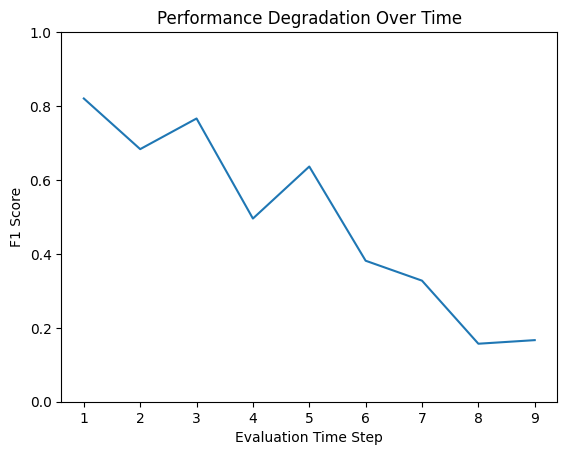

In [32]:
plt.plot(list(range(1, len(f1_list)+1)), f1_list)
plt.title("Performance Degradation Over Time")
plt.ylim(0,1)
plt.ylabel("F1 Score")
plt.xlabel("Evaluation Time Step")
plt.savefig("degradeelliptic.png", dpi=400)
plt.show()

In [34]:
sum(f1_list) / len(f1_list)

0.49274156669450275